In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from database.connection import sql_connection
from database.dataset import dataset_config
import lightgbm as lgb
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from plots import plots
import numpy as np
import pandas as pd

In [2]:
random_state=1
stdrings = sql_connection.set_standard_rings_data()
# params=[[{'cluster_eta':[0.6, 0.8]}, {'cluster_et':[20000,30000]}],
#         [{'cluster_eta':[1.2, 1.8]}, {'cluster_et':[100000, 250000]}]]

dataset=dataset_config.split_dataframe(stdrings, params=None)
data = dataset_config.prepare_and_split_data(
    input_type='std_rings',
    stdrings_df=stdrings,
    train_size= 0.7,
    random_state=random_state
)

In [3]:
print("-- Training and Testing Sets Shape --", '\n')
print("XtrT.shape = ", data[0][0].shape)    
print("ytr.shape =  ", data[0][1].shape)
print("XteT.shape = ", data[0][2].shape)
print("yte.shape =  ", data[0][3].shape)

print(data[0][0].columns.to_list())

-- Training and Testing Sets Shape -- 

XtrT.shape =  (371007, 51)
ytr.shape =   (159003, 51)
XteT.shape =  (371007,)
yte.shape =   (159003,)
['StdRings_0', 'StdRings_1', 'StdRings_2', 'StdRings_3', 'StdRings_8', 'StdRings_9', 'StdRings_10', 'StdRings_11', 'StdRings_12', 'StdRings_13', 'StdRings_14', 'StdRings_15', 'StdRings_16', 'StdRings_17', 'StdRings_18', 'StdRings_19', 'StdRings_20', 'StdRings_21', 'StdRings_22', 'StdRings_23', 'StdRings_24', 'StdRings_25', 'StdRings_26', 'StdRings_27', 'StdRings_28', 'StdRings_29', 'StdRings_30', 'StdRings_31', 'StdRings_32', 'StdRings_33', 'StdRings_34', 'StdRings_35', 'StdRings_36', 'StdRings_37', 'StdRings_38', 'StdRings_39', 'StdRings_40', 'StdRings_72', 'StdRings_73', 'StdRings_74', 'StdRings_75', 'StdRings_80', 'StdRings_81', 'StdRings_82', 'StdRings_83', 'StdRings_88', 'StdRings_89', 'StdRings_90', 'StdRings_91', 'StdRings_92', 'StdRings_93']


In [4]:
space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 700),
    Integer(name='max_depth', low = 200, high = 700),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    "boosting_type": "gbdt",
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 500,
    'random_state': random_state, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=5, verbose=False)]}
optimization_kwargs = {'n_initial_points': 1,
                        'n_calls': 2,
                        'initial_point_generator': 'lhs',
                        'random_state': random_state,

                       
                       }

# Simplesmente passe 'model_type="lightgbm"'
optimizer_lgbm = RunOptimization()
results=optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs

)



Optimization finished.
Best score (mean_absolute_error): 0.0558
Best parameters: {'learning_rate': 0.6353540432754794, 'num_leaves': np.int64(231), 'max_depth': np.int64(388), 'feature_fraction': 0.5728216976987587, 'bagging_fraction': 0.8479526421199437, 'bagging_freq': np.int64(9), 'lambda_l1': 0.058487185908451034, 'lambda_l2': 0.6278474089136892}

To train the final model with these parameters, call the '.fit_best_model()' method.


In [5]:
parameters_run_model = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 30,
    "max_depth": 7,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "force_row_wise": True,
    "verbosity": -1
}

parameters_run_model_1 = {
    "boosting_type": "gbdt",
    "objective": "mae",
    "metric": ["mae"],
    "num_leaves": 139,
    "max_depth": 300,
    "learning_rate": 0.095,
    "feature_fraction": 0.8,
    "bagging_fraction": 1,
    "bagging_freq": 10,
    "num_boost_round": 1000,
    "early_stopping_rounds": 5,
    "lambda_l1": 0.02,
    "lambda_l2": 0.72,
    "force_row_wise": True,
    "verbosity": -1
}

parameters_run_model_2 = {
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['mae'],
    'num_leaves': np.int64(652),
    'max_depth': np.int64(610),
    'learning_rate': 0.03818654645154271,
    'feature_fraction': 0.9039401105949553,
    'bagging_fraction': 0.7960565139652669,
    'bagging_freq': np.int64(6),
    'num_boost_round': np.int64(534),
    'early_stopping_rounds': 5,
    'lambda_l1': 0.4069025545005863,
    'lambda_l2': 0.6767363223435275,
    'force_row_wise': True,
    'verbosity': -1}

# Simplesmente passe 'model_type="lightgbm"'
lgbm_model = RunModel()
results_lgbm_model=lgbm_model.run(
    model_class="lgbm",
    datasets=data,
    params=parameters_run_model,
    calibration_kwargs= calibration_kwargs
)

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [6]:
y_test = []
y_pred = []

for i in range(len(optimizer_lgbm.optimizer)):   
    optimizer_lgbm.optimizer[i].get_best_model() 

    y_test.append(optimizer_lgbm.optimizer[i].y_test)
    y_pred.append(optimizer_lgbm.optimizer[i].y_pred) 

Training the final model with the best parameters...
Final model has been trained and is stored in the '.best_model_' attribute.


In [7]:
merged_dataframe=[]
merged_dataframe_lgbm_models=[]

for i in range(len(optimizer_lgbm.optimizer)):
    merged_dataframe.append(plots.merge_dataframes(
        stdrings.loc[optimizer_lgbm.optimizer[i].y_test.index],
        y_test[i],
        y_pred[i])
    )
    
merged_dataframe = pd.concat(merged_dataframe, ignore_index=True)


lgbm_model.models[0].predict(results_lgbm_model[0])
for i in range(len(lgbm_model.models)):
    merged_dataframe_lgbm_models.append(plots.merge_dataframes(
        stdrings.loc[lgbm_model.models[i].y_test.index],
        lgbm_model.models[i].y_test, 
        lgbm_model.models[i].y_pred)
    )
merged_dataframe_lgbm_models = pd.concat(merged_dataframe_lgbm_models, ignore_index=True)


In [8]:
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000,
                          900000, 3000000]}
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}
et_metric=plots.parameters_filter(merged_dataframe, bins_et)
eta_metric=plots.parameters_filter(merged_dataframe, bins_eta)
et_plot=plots.evaluate_metrics(et_metric, y_test_col='alpha', y_pred_col='y_pred')
eta_plot=plots.evaluate_metrics(eta_metric, y_test_col='alpha', y_pred_col='y_pred')


et_plot_params={'y_data': et_plot,}
eta_plot_params={'y_data': eta_plot,}


In [9]:
et_metric_models=plots.parameters_filter(merged_dataframe_lgbm_models, bins_et)
eta_metric_models=plots.parameters_filter(merged_dataframe_lgbm_models, bins_eta)
et_plot_models=plots.evaluate_metrics(et_metric_models, y_test_col='alpha', y_pred_col='y_pred')
eta_plot_models=plots.evaluate_metrics(eta_metric_models, y_test_col='alpha', y_pred_col='y_pred')


et_plot_params_models={'y_data': et_plot_models,}
eta_plot_params_models={'y_data': eta_plot_models,}


print(eta_plot_params)
print(et_plot_params)

{'y_data': [np.float64(0.02169296212644023), np.float64(0.02963990899198743), np.float64(0.03228932862973344), np.float64(0.0331777655216563), np.float64(0.06405873052157696), np.float64(0.053378161867154605), np.float64(0.029686099437618907), np.float64(0.02742367662178191), np.float64(0.029511645612773862)]}
{'y_data': [np.float64(0.14559695167617548), np.float64(0.08450544954437), np.float64(0.05692648744067497), np.float64(0.046418645761793886), np.float64(0.040133628970902446), np.float64(0.034785404525466745), np.float64(0.02982313968340522), np.float64(0.026021391789456616), np.float64(0.023558519318321758), np.float64(0.02245560999747309), np.float64(0.022484874101228125), np.float64(0.025808525308153696)]}


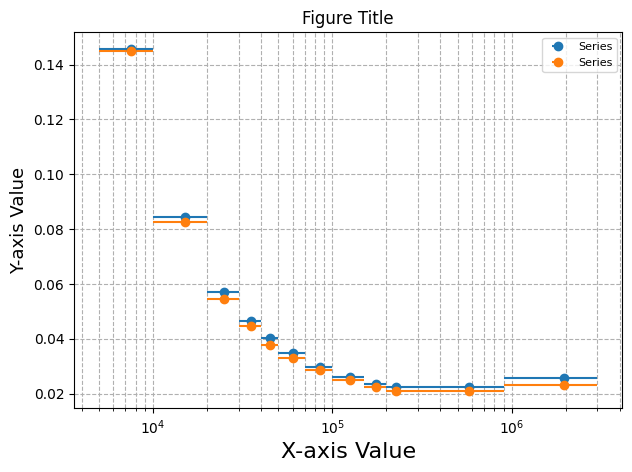

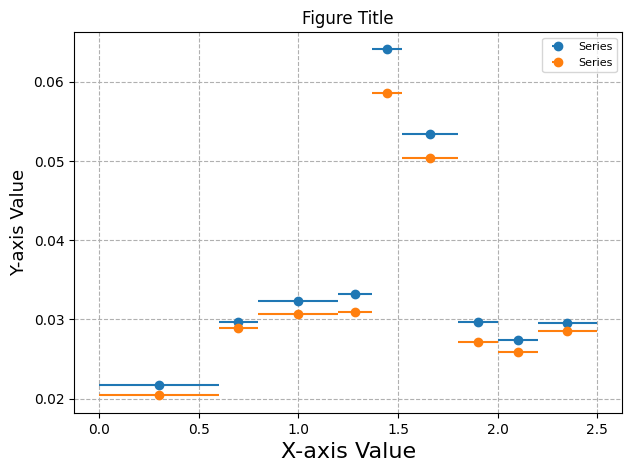

In [10]:
plots.plot_errorbars(plot_configs=[et_plot_params, et_plot_params_models],bins=bins_et,xscale='log')
plots.plot_errorbars(plot_configs=[eta_plot_params, eta_plot_params_models],bins=bins_eta)